In [144]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

### Load Dataset

In [122]:
stroke_data = pd.read_csv("./data/stroke_prediction_dataset.csv")
stroke_data.head()

,Patient ID,Patient Name,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,...,Alcohol Intake,Physical Activity,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Blood Pressure Levels,Cholesterol Levels,Symptoms,Diagnosis
0,18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,...,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
1,62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,...,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
2,32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,...,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
3,6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,...,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Head...",No Stroke
4,48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,...,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke


### Data Preprocessing

In [123]:
# Preprocess the Dataset
stroke_data['Family History of Stroke'] = stroke_data['Family History of Stroke'] + " Family History"
stroke_data['Family History of Stroke'].value_counts()

Yes Family History    7592
No Family History     7408
Name: Family History of Stroke, dtype: int64

In [124]:
stroke_data['Physical Activity'] = stroke_data['Physical Activity'] + " Physical Activity"
stroke_data['Physical Activity'].value_counts()

High Physical Activity        5060
Moderate Physical Activity    4998
Low Physical Activity         4942
Name: Physical Activity, dtype: int64

In [125]:
stroke_data['Alcohol Intake'] = stroke_data['Alcohol Intake'].map({"Never": "Never Drinks", "Rarely": "Rarely Drinks", 'Frequent Drinker': 'Frequent Drinker', "Social Drinker": "Social Drinker"})
stroke_data['Alcohol Intake'].value_counts()

Rarely Drinks       3821
Social Drinker      3745
Never Drinks        3729
Frequent Drinker    3705
Name: Alcohol Intake, dtype: int64

In [126]:
# separate Diastolic and Systolic
stroke_data['Systolic'] = stroke_data['Blood Pressure Levels'].apply(lambda bp: int(bp.split("/")[0]))
stroke_data['Diastolic'] = stroke_data['Blood Pressure Levels'].apply(lambda bp: int(bp.split("/")[1]))
del stroke_data['Blood Pressure Levels']

In [127]:
# Separate HDL and LDL
stroke_data['HDL'] = stroke_data['Cholesterol Levels'].apply(lambda cl: int(re.findall("[0-9]{1,}", cl)[0]))
stroke_data['LDL'] = stroke_data['Cholesterol Levels'].apply(lambda cl: int(re.findall("[0-9]{1,}", cl)[-1]))
del stroke_data['Cholesterol Levels']

In [128]:
stroke_data.head()

,Patient ID,Patient Name,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,...,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Symptoms,Diagnosis,Systolic,Diastolic,HDL,LDL
0,18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,...,0,Yes Family History,Vegan,3.48,"Difficulty Speaking, Headache",Stroke,140,108,68,133
1,62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,...,0,No Family History,Paleo,1.73,"Loss of Balance, Headache, Dizziness, Confusion",Stroke,146,91,63,70
2,32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,...,0,Yes Family History,Paleo,7.31,"Seizures, Dizziness",Stroke,154,97,59,95
3,6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,...,0,No Family History,Paleo,5.35,"Seizures, Blurred Vision, Severe Fatigue, Head...",No Stroke,174,81,70,137
4,48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,...,0,Yes Family History,Pescatarian,6.84,Difficulty Speaking,Stroke,121,95,65,68


In [129]:
features = stroke_data.columns
features

Index(['Patient ID', 'Patient Name', 'Age', 'Gender', 'Hypertension',
       'Heart Disease', 'Marital Status', 'Work Type', 'Residence Type',
       'Average Glucose Level', 'Body Mass Index (BMI)', 'Smoking Status',
       'Alcohol Intake', 'Physical Activity', 'Stroke History',
       'Family History of Stroke', 'Dietary Habits', 'Stress Levels',
       'Symptoms', 'Diagnosis', 'Systolic', 'Diastolic', 'HDL', 'LDL'],
      dtype='object')

### Probabilistic Analysis

In [130]:
# All of the categorical features.
cat_features = ['Gender', 'Hypertension',
                'Heart Disease', 'Marital Status', 'Work Type', 'Residence Type', 'Smoking Status',
                'Alcohol Intake', 'Physical Activity', 'Stroke History',
                'Family History of Stroke', 'Dietary Habits', 'Diagnosis']

In [131]:
# Define a probability calculation function
def find_prob(data: pd.DataFrame, A: str, B: str, debug=True) -> float:
    # Find Probability of P(B | A)
    # P(B|A) = P(A and B) / P(A)

    # Get the unique categorical values of A and B
    cat_vals_A = data[A].unique()
    cat_vals_B = data[B].unique()

    # Calculate total number of people in population
    total = data.shape[0]

    # First Calculate P(A and B) and P(A)
    for a_val in cat_vals_A:

        str_a = a_val
        if a_val == 1:
            str_a = f"Positive {A}"
        elif a_val == 0:
            str_a = f"Negative {A}"

        P_a = data[stroke_data[A] == a_val].shape[0] / total
        if debug:
            print(f"P({str_a}) = {int(P_a * total)} / {total} = {P_a}")
        yield f"P({str_a})", P_a

        for b_val in cat_vals_B:
            P_a_b = data[(data[A] == a_val) & (data[B] == b_val)].shape[0] / total
            P_b_given_a = P_a_b / P_a

            str_b = b_val
            if b_val == 1:
                str_b = f"Positive {B}"
            elif b_val == 0:
                str_b = f"Negative {B}"

            yield f"P({str_b}, {str_a})", P_a_b

            if debug:
                print(f"P({str_b} | {str_a}) = ({int(P_a_b * total)} / {total}) / ({int(P_a*total)} / {total}) = {P_b_given_a}")
            yield f"P({str_b} | {str_a})", P_b_given_a
                

In [132]:
probability_dict = {}

for feat in cat_features:
    for feat_2 in cat_features:
        if feat == feat_2: # Skip duplicates
            continue
        for key, prob_val in find_prob(stroke_data, feat, feat_2):
            probability_dict[key] = prob_val

P(Male) = 7622 / 15000 = 0.5081333333333333
P(Negative Hypertension | Male) = (5703 / 15000) / (7622 / 15000) = 0.7482288113356075
P(Positive Hypertension | Male) = (1919 / 15000) / (7622 / 15000) = 0.2517711886643926
P(Female) = 7378 / 15000 = 0.4918666666666667
P(Negative Hypertension | Female) = (5562 / 15000) / (7378 / 15000) = 0.7538628354567634
P(Positive Hypertension | Female) = (1816 / 15000) / (7378 / 15000) = 0.24613716454323664
P(Male) = 7622 / 15000 = 0.5081333333333333
P(Positive Heart Disease | Male) = (3853 / 15000) / (7622 / 15000) = 0.5055103647336657
P(Negative Heart Disease | Male) = (3769 / 15000) / (7622 / 15000) = 0.4944896352663344
P(Female) = 7378 / 15000 = 0.4918666666666667
P(Positive Heart Disease | Female) = (3691 / 15000) / (7378 / 15000) = 0.5002710761724044
P(Negative Heart Disease | Female) = (3687 / 15000) / (7378 / 15000) = 0.49972892382759554
P(Male) = 7622 / 15000 = 0.5081333333333333
P(Married | Male) = (2425 / 15000) / (7622 / 15000) = 0.3181579637

In [133]:
# Sort our probability values
probability_dict = dict(sorted(probability_dict.items(), reverse=True, key=lambda x:x[1]))

In [134]:
# Looking at this dictionary of probability values, we can make a stronger assumption that
# the final diagnosis will be dependent on multiple variables.
probability_dict

{'P(Negative Hypertension | Keto)': 0.7625292740046837,
 'P(Negative Hypertension | Never Drinks)': 0.7589165996245643,
 'P(Negative Hypertension | Non-Vegetarian)': 0.7588619402985075,
 'P(Negative Hypertension | Government Job)': 0.7579514824797844,
 'P(Negative Hypertension | Low Physical Activity)': 0.7577903682719547,
 'P(Negative Hypertension | No Family History)': 0.7574244060475162,
 'P(Negative Hypertension | Frequent Drinker)': 0.7562753036437246,
 'P(Negative Hypertension | Stroke)': 0.7560257096946974,
 'P(Negative Hypertension | Formerly Smoked)': 0.7560240963855421,
 'P(Negative Hypertension | Negative Stroke History)': 0.7546691568836713,
 'P(Negative Hypertension | Pescatarian)': 0.7545109211775879,
 'P(Negative Hypertension | Female)': 0.7538628354567634,
 'P(Negative Hypertension | Moderate Physical Activity)': 0.7533013205282113,
 'P(Negative Hypertension | Paleo)': 0.7531934306569342,
 'P(Negative Hypertension | Negative Heart Disease)': 0.7520118025751074,
 'P(Nega

### Continuous Variables vs Diagnosis Distribution Evaluation

In [171]:
from typing import Tuple

# Because I'm calculating these values by hand i have
# to mess up how we calculate distributions
# and fake the distirbution by forcing it 
# to represent my actual findings.
def convert_heights_to_dist(bin_heights, bins):
    fake = np.array([])
    for i in range(len(bin_heights)):
        a, b = bins[i], bins[i+1]
        sample = a + (b-a)*np.random.rand(bin_heights[i])
        fake = np.append(fake, sample)
    return fake

def get_cont_vs_diag_dist(data: pd.DataFrame, bin_col: str, bins=10) -> Tuple[list[int], list[float]]:
    # Create dataframe for grouping and analysis
    _, bins = np.histogram(data[bin_col], bins)
    series_data = pd.cut(data[bin_col], bins=bins).rename(f"{bin_col}_Interval")
    temp_df = pd.concat([data, series_data], axis=1)

    groups = temp_df.groupby(f"{bin_col}_Interval")
    bin_groups = temp_df[f"{bin_col}_Interval"].unique()
    
    bin_heights = []
    for interval in bin_groups:
        if type(interval) == float:
            continue
        bin_heights.append(groups.get_group(interval)['Diagnosis'].value_counts()['Stroke'])

    plt.hist(convert_heights_to_dist(bin_heights, bins), bins=bins, alpha=0.5, label="Stroke")

    bin_heights = []
    for interval in bin_groups:
        if type(interval) == float:
            continue
        bin_heights.append(groups.get_group(interval)['Diagnosis'].value_counts()['No Stroke'])

    plt.hist(convert_heights_to_dist(bin_heights, bins), bins=bins, alpha=0.5, label="No Stroke")

    plt.legend(loc='lower right')    
    plt.show()
    
    return bin_heights, list(bins)
    

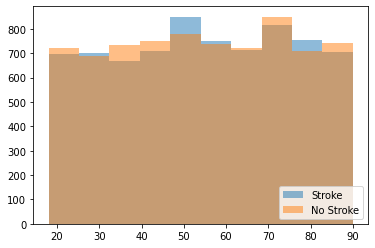

In [172]:
heights, bins = get_cont_vs_diag_dist(stroke_data, 'Age', 10)

In [173]:
stroke_data['HDL'].dtype

dtype('int64')

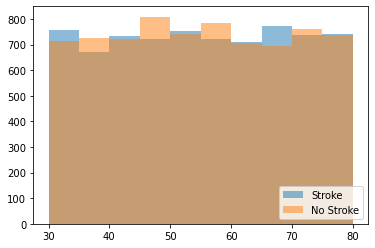

In [174]:
heights, bins = get_cont_vs_diag_dist(stroke_data, 'HDL', 10)

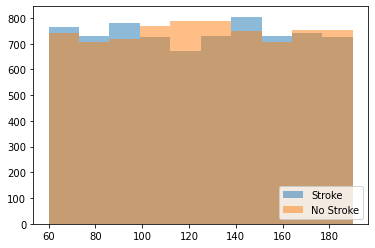

In [175]:
heights, bins = get_cont_vs_diag_dist(stroke_data, 'LDL', 10)

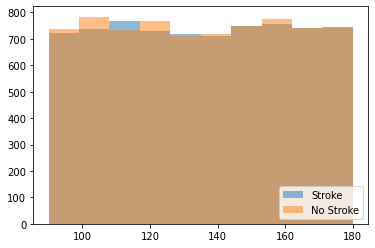

In [176]:
heights, bins = get_cont_vs_diag_dist(stroke_data, 'Systolic', 10)

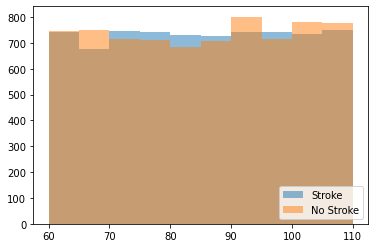

In [177]:
heights, bins = get_cont_vs_diag_dist(stroke_data, 'Diastolic', 10)